# Importing packages

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import tensorflow as tf

from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, mean_absolute_error, r2_score,plot_confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, train_test_split, KFold,GridSearchCV,RepeatedStratifiedKFold 
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, RobustScaler, OrdinalEncoder
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.feature_selection._base import SelectorMixin
from sklearn.feature_extraction.text import _VectorizerMixin

In [2]:
from yellowbrick.model_selection import FeatureImportances
from sklearn.linear_model import Lasso
from yellowbrick.regressor import residuals_plot,prediction_error
from yellowbrick.model_selection import learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor,GradientBoostingRegressor, ExtraTreesRegressor
from yellowbrick.model_selection import feature_importances
import xgboost as xgb

In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
import warnings # Ignore alert messages
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
plt.rcParams.update({
    'font.size': 18,
    'axes.linewidth':2,
    'axes.titlesize': 20,
    'lines.linewidth' : 1.5,
    'lines.markersize' : 10,
    'figure.figsize': (25,10),
    'xtick.labelsize': 15, 
    'ytick.labelsize': 15,
    'font.family': 'Arial',
    'legend.fontsize':14,
    'axes.labelsize':20,
    'axes.grid':True,
})

# Importing dataset

In [6]:
df_train = pd.read_csv('Processed_data/df.csv.zip')

In [7]:
df_train    

,Time(s),Flow_Rate(ml/m),Upstream_Pressure(psi),Downstream_Pressure(psi),Sample,Particle Size (micron),Solid Ratio(%),Pressure drop (psi),RUL,TTF
0,0.0,1.812877,-0.055907,-0.966327,1,45-53,0.400,0.910420,276.0,324.9
1,0.1,0.344843,-0.046198,-0.924724,1,45-53,0.400,0.878527,275.9,324.8
2,0.2,-1.163908,-0.035887,-0.882879,1,45-53,0.400,0.846992,275.8,324.7
3,0.3,-2.708819,-0.024998,-0.840871,1,45-53,0.400,0.815873,275.7,324.6
4,0.4,-4.284941,-0.013557,-0.798784,1,45-53,0.400,0.785227,275.6,324.5
...,...,...,...,...,...,...,...,...,...,...
69862,172.8,409.525546,19.303218,-0.051227,48,63-75,0.475,19.354445,0.4,61.1
69863,172.9,409.866834,19.449701,-0.049585,48,63-75,0.475,19.499287,0.3,61.0
69864,173.0,410.229758,19.595829,-0.047829,48,63-75,0.475,19.643658,0.2,60.9
69865,173.1,410.613080,19.741549,-0.045959,48,63-75,0.475,19.787507,0.1,60.8


# Exploratory data analysis (EDA)

**Questions to be answered:**

- How much does particle size and solid ratio affect the RUL?
- How much do the samples differ from each other? 
- Is 20 psi the optimal limit for defining when the filter is clogged? 

## How much does particle size and solid ratio affect the RUL?

<AxesSubplot:xlabel='Sample', ylabel='Time(s)'>

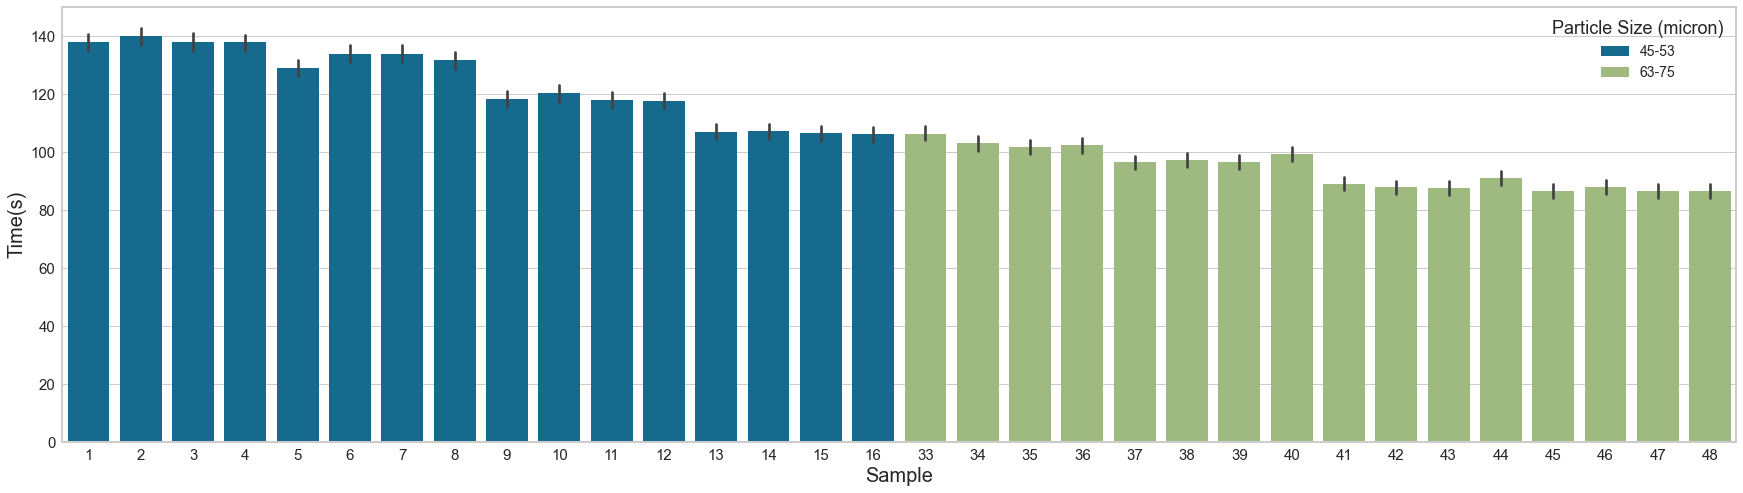

In [8]:
plt.figure(figsize=(30, 8))
sns.barplot(data=df_train,
            x="Sample", 
            y="Time(s)", 
            hue="Particle Size (micron)", 
            dodge=False
            )

<AxesSubplot:xlabel='Sample', ylabel='Time(s)'>

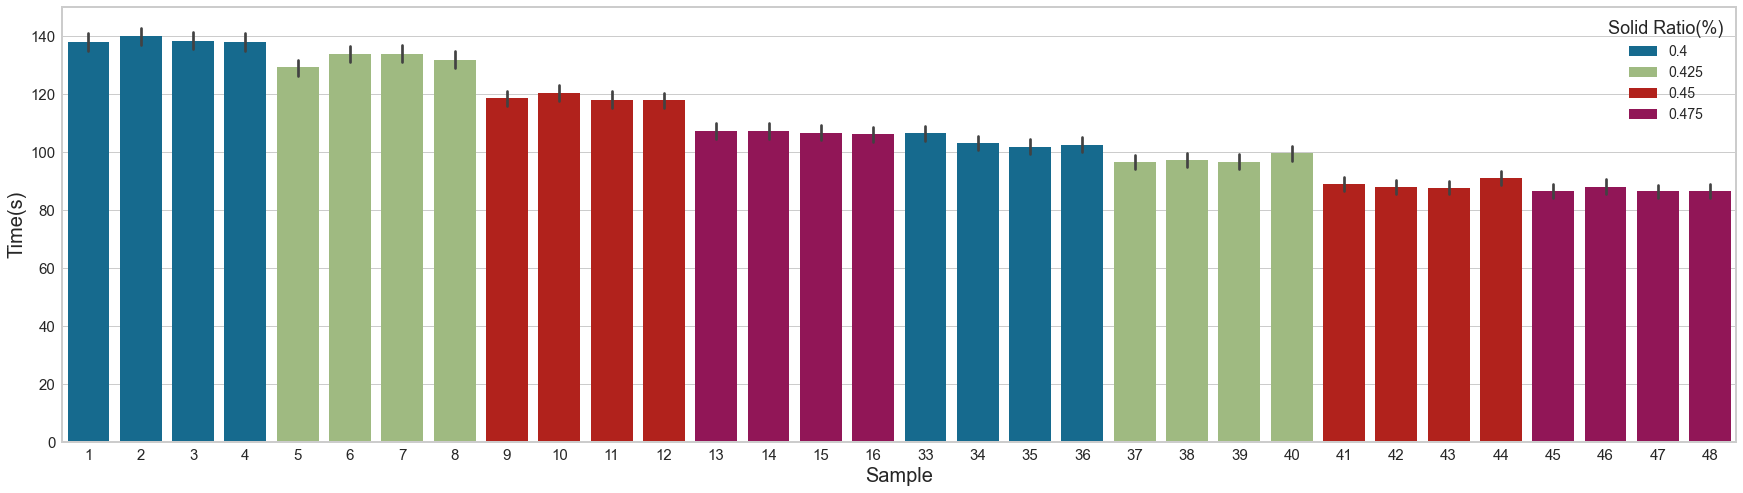

In [9]:
plt.figure(figsize=(30, 8))
sns.barplot(data=df_train,
            x="Sample", 
            y="Time(s)", 
            hue='Solid Ratio(%)', 
            dodge=False
            )

**Conclusions:**

- Larger particles lead to worse RUL
- Solid ratio doesn't seem to be an important variable due to their wide range of values

## How much do the samples differ?

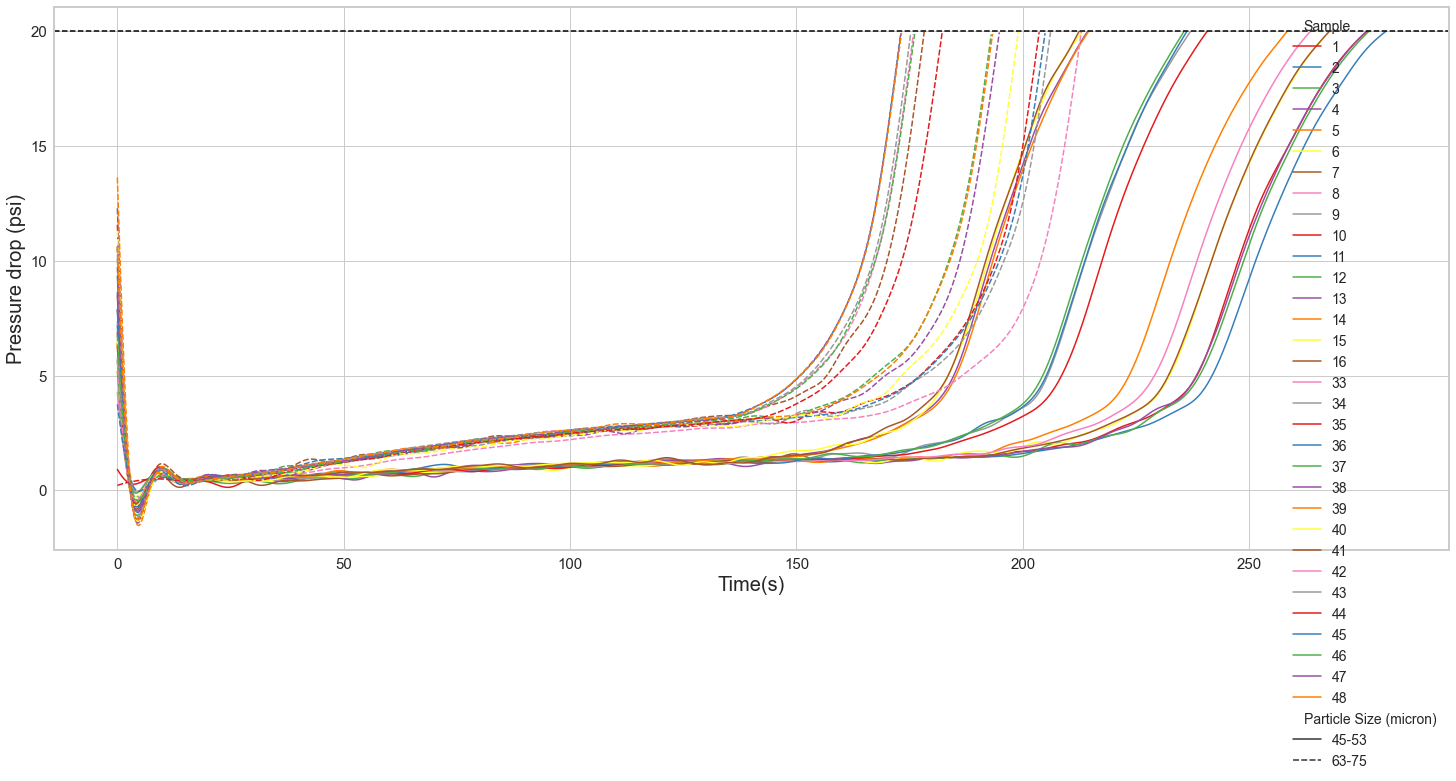

In [10]:
sns.lineplot(data=df_train,
             x='Time(s)',
             y='Pressure drop (psi)',
             hue='Sample',
             style='Particle Size (micron)',
             palette='Set1')

plt.axhline(y = 20, color = 'black', linestyle = 'dashed')    

<AxesSubplot:xlabel='Time(s)', ylabel='Flow_Rate(ml/m)'>

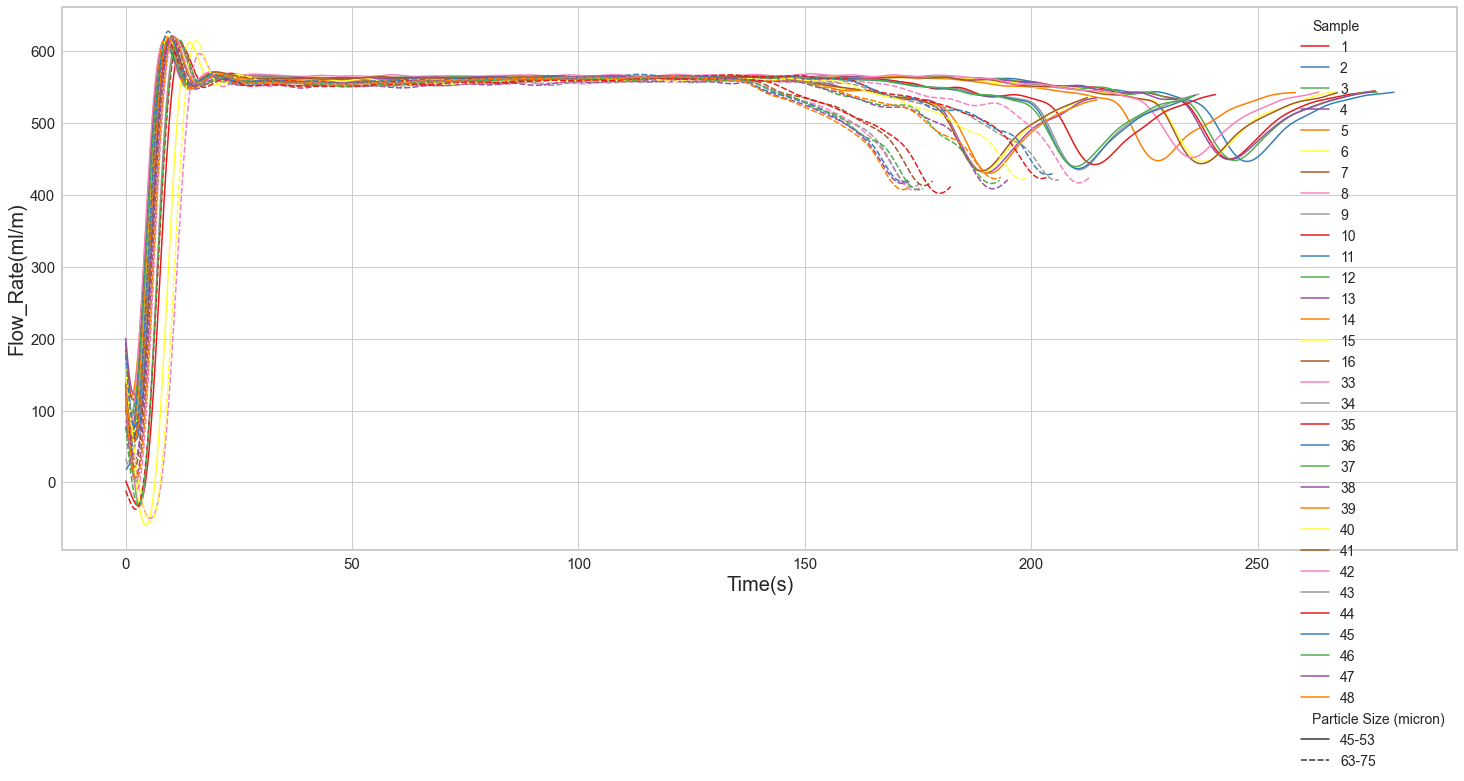

In [11]:
sns.lineplot(data=df_train,
             x='Time(s)',
             y='Flow_Rate(ml/m)',
             hue='Sample',
             style='Particle Size (micron)',
             palette='Set1') 

## Is 20 psi the optimal limit for defining when the filter is clogged? 

This section is only useful when using the entire dataset.

In [12]:
# #df_filtered = df_train.loc[(df_train['Clogged']==1)] # Obtaining all clogged instances

# sns.lineplot(data=df_train,
#              x='Time(s)',
#              y='Pressure drop (psi)',
#              hue='Sample',
#              style='Particle Size (micron)',
#              palette='seismic')

# plt.axhline(y = 20, color = 'green', linestyle = 'dashed')    

The limit of 20 psi (green dashed line) is not an optimal definition of when the filter is clogged. The filter is clogged when a different characteristic is observed. In this case, the beginning of an exponential trend is the indication of the clogged condition. 

- For small particle sizes, 20 psi is very close to the end of RUL. 
- For large particle sizes, 20 psi is in the middle of the exponential trend. This can also be optimized further up 25 psi so that it is similar to the small particle case

With this in mind, we will still use 20 psi because this was the proposed value from the challenge.

# Correlation between variables

## Univariate correlation

In [13]:
def scatterplot_pearson(df, x_vars, y_vars, cmap='seismic',hue='Class'):
    sns.set(font_scale=1.9)
    g = sns.PairGrid(df, hue=hue, x_vars=x_vars,y_vars=y_vars, palette=cmap, corner=False,height=7,aspect=1)
    g.map_diag(sns.histplot, color='.5')
    g.map_offdiag(sns.scatterplot, s=5,alpha=0.7)
    g.tight_layout()
    g.add_legend()
    return g

def dual_heat_map(data,figsize=(25,15),dual=True):
    
    sns.set(font_scale=1.1)
    corr_pearson=data.corr(method='pearson')
    corr_spearman=data.corr(method='spearman')

    mask = np.zeros_like(corr_pearson)
    mask[np.triu_indices_from(mask)] = True

    if dual:
        fig, ax = plt.subplots(nrows=1,ncols=2,figsize=figsize)
        sns.heatmap(corr_pearson,cmap="coolwarm", linewidths=0.5, annot=True, annot_kws={"size":14},mask=mask,square=True,ax=ax[0],fmt='.2f',cbar=False)
        sns.heatmap(corr_spearman,cmap="coolwarm", linewidths=0.5, annot=True, annot_kws={"size":14},mask=mask,square=True,ax=ax[1],fmt='.2f',cbar=False)
        ax[0].set_title('Pearson correlation')
        ax[1].set_title('Spearman correlation')
        plt.show()
        
    else:
        fig, ax = plt.subplots(nrows=1,ncols=1,figsize=figsize)
        sns.heatmap(corr_pearson,cmap="coolwarm", linewidths=0.5, annot=True, annot_kws={"size":14},mask=mask,square=True,fmt='.2f',cbar=False)
        ax.set_title('Pearson correlation')
        plt.show()  
    
    return

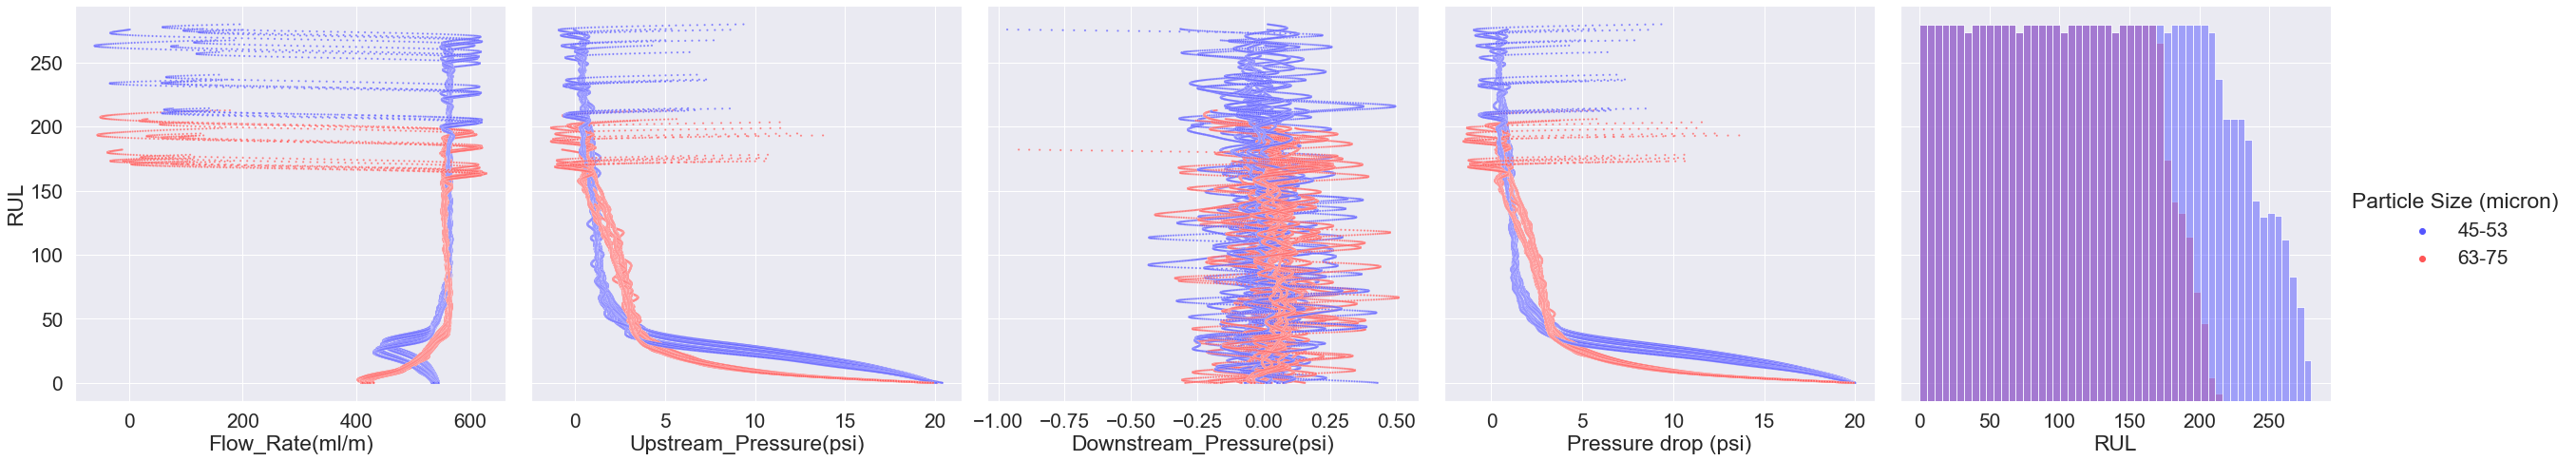

In [14]:
x_vars = ['Flow_Rate(ml/m)','Upstream_Pressure(psi)','Downstream_Pressure(psi)','Pressure drop (psi)','RUL']
y_vars = ['RUL']

scatterplot_pearson(df=df_train, x_vars=x_vars, y_vars=y_vars,hue="Particle Size (micron)")

Looks like downstream pressure has no relationship with the RUL. The rest exhibit a polynomial relationship

In [15]:
df_aux = df_train.copy()

le = LabelEncoder()
df_aux['Particle Size (micron)'] = le.fit_transform(df_aux['Particle Size (micron)'])

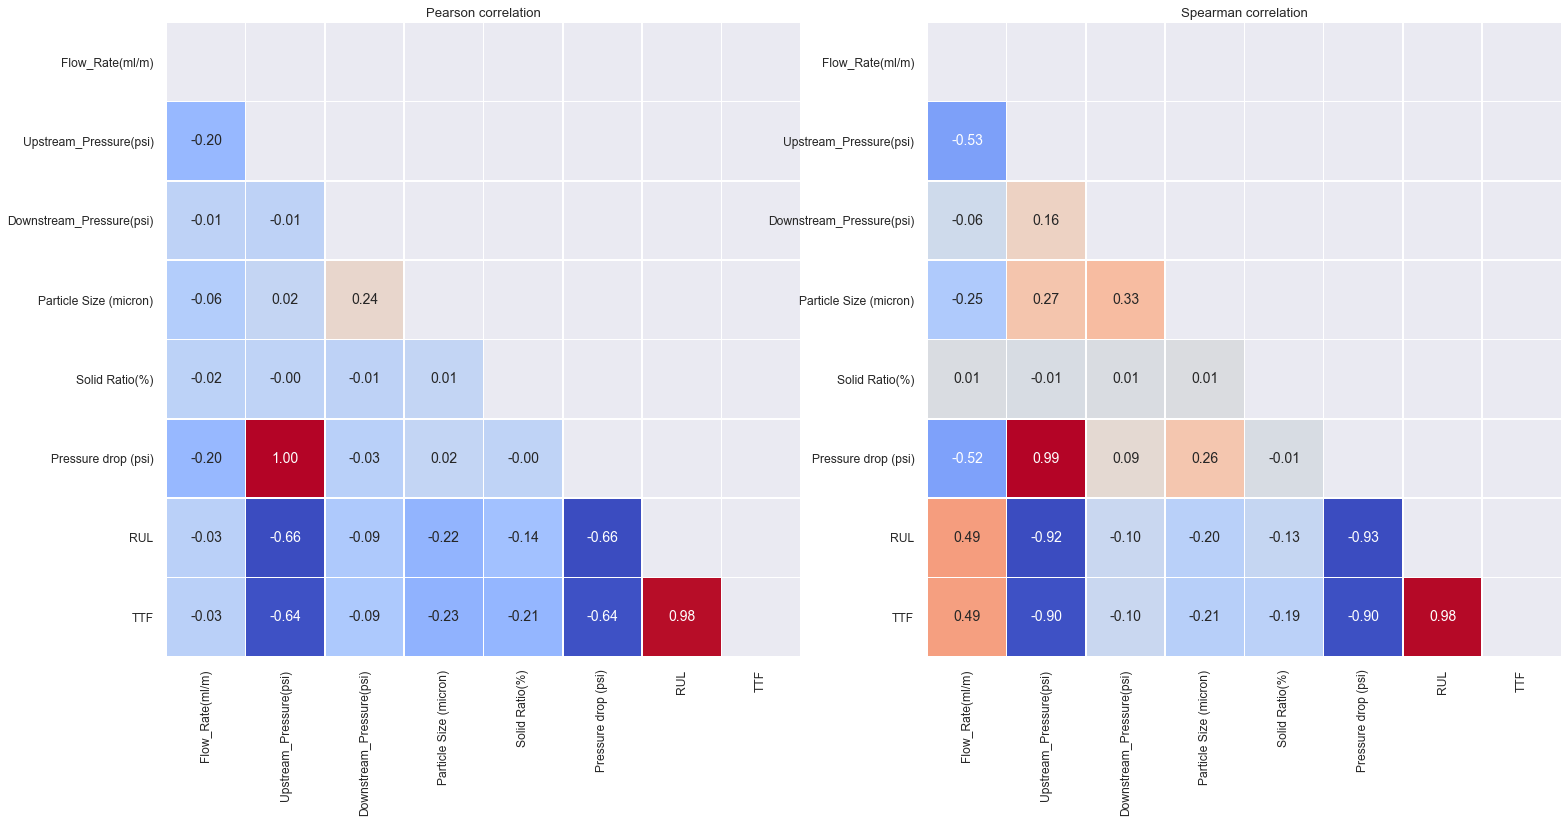

In [16]:
df_aux.drop(['Time(s)','Sample'],axis=1,inplace=True)
dual_heat_map(df_aux,figsize=(25,15),dual=True)

From the heatmap, we see that:

- Downstream pressure has no relationship with RUL;
- Upstream pressure is highly correlated with pressure drop;
- Flowrate (0.49), Upstream pressure (-0.92) and pressure drop (-0.90) have good correlation with the target. These will be our selected variables.
- Particle size and solid ratio don't seem that important, however, we will keep them because maybe multivariate correlation will shows its importance

In [17]:
df_train.drop(['Upstream_Pressure(psi)','Downstream_Pressure(psi)'],axis=1,inplace=True)
df_train

,Time(s),Flow_Rate(ml/m),Sample,Particle Size (micron),Solid Ratio(%),Pressure drop (psi),RUL,TTF
0,0.0,1.812877,1,45-53,0.400,0.910420,276.0,324.9
1,0.1,0.344843,1,45-53,0.400,0.878527,275.9,324.8
2,0.2,-1.163908,1,45-53,0.400,0.846992,275.8,324.7
3,0.3,-2.708819,1,45-53,0.400,0.815873,275.7,324.6
4,0.4,-4.284941,1,45-53,0.400,0.785227,275.6,324.5
...,...,...,...,...,...,...,...,...
69862,172.8,409.525546,48,63-75,0.475,19.354445,0.4,61.1
69863,172.9,409.866834,48,63-75,0.475,19.499287,0.3,61.0
69864,173.0,410.229758,48,63-75,0.475,19.643658,0.2,60.9
69865,173.1,410.613080,48,63-75,0.475,19.787507,0.1,60.8


## Multivariate correlation

In [18]:
class multivariate_importance():
    def __init__(self, X_train,X_test,y_train,y_test,nmodels=6):
        
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.nmodels = nmodels
        
        mod1 = Lasso()
        mod2 = RandomForestRegressor(random_state=0)
        mod3 = AdaBoostRegressor(random_state=0)
        mod4 = GradientBoostingRegressor(random_state=0)
        mod5 = ExtraTreesRegressor(random_state=0)
        mod6 = xgb.XGBRegressor(seed=123,gpu_id=0,tree_method='gpu_hist',random_state=0)
        
        self.mod_list = [mod1,mod2,
                         mod3,mod4,
                         mod5,mod6]
        
        self.mod_list = self.mod_list[0:self.nmodels]
        
        self.model_r2 = None
        
        print('All models for determining feature importance')
        print(self.mod_list)
        print('')
        
    def train_models(self):
        
        model_r2 = []
        for model in tqdm(self.mod_list):
            model.fit(self.X_train,self.y_train)
            model_r2.append(np.round(r2_score(self.y_test,model.predict(self.X_test)),4)) 
    
        self.model_r2 = model_r2
        
        return model_r2
    
    def permutation_importance(self,model_index=1):

        self.mod_list[model_index].fit(self.X_train,self.y_train)
        perm = PermutationImportance(self.mod_list[model_index], random_state=1).fit(self.X_train,self.y_train)
        return eli5.show_weights(perm, feature_names = X_train.columns.tolist())
    
    def plot(self,relative=True,topn=8,absolute=True,plot_R2=True):
        
        fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(30, 18))
        
        print('Obtaining feature importance - 0%')
        viz1 = FeatureImportances(self.mod_list[0],relative=relative,topn=topn,ax=ax[0,0],absolute=absolute)
        viz1.fit(self.X_train,self.y_train)
        ax[0,0].tick_params(labelsize=13)
        
        viz2 = FeatureImportances(self.mod_list[1],relative=relative,topn=topn,ax=ax[0,1],absolute=absolute)
        viz2.fit(self.X_train,self.y_train)
        ax[0,1].tick_params(labelsize=13)
        
        viz3 = FeatureImportances(self.mod_list[2],relative=relative,topn=topn,ax=ax[0,2],absolute=absolute)
        viz3.fit(self.X_train,self.y_train)
        ax[0,2].tick_params(labelsize=13)
        print('Obtaining feature importance - 50%')
        viz4 = FeatureImportances(self.mod_list[3],relative=relative,topn=topn,ax=ax[1,0],absolute=absolute)
        viz4.fit(self.X_train,self.y_train)
        ax[1,0].tick_params(labelsize=13)
        
        viz5 = FeatureImportances(self.mod_list[4],relative=relative,topn=topn,ax=ax[1,1],absolute=absolute) 
        viz5.fit(self.X_train,self.y_train)
        ax[1,1].tick_params(labelsize=13)
        
        viz6 = FeatureImportances(self.mod_list[5],relative=relative,topn=topn,ax=ax[1,2],absolute=absolute)
        viz6.fit(self.X_train,self.y_train)
        ax[1,2].tick_params(labelsize=13)   
        print('Obtaining feature importance - 100%')   
          
        if plot_R2:
            
            if self.model_r2 == None:
                print('Obtaining R2 score for all 6 models')
                multivariate_importance.train_models(self)
                print('R2 score calculated')
                
            ax[0,0].set_title('Lasso Regression - $R^2$ = {}'.format(self.model_r2[0]),fontsize=16)
            ax[0,1].set_title('RandomForestRegressor - $R^2$ = {}'.format(self.model_r2[1]),fontsize=16)
            ax[0,2].set_title('AdaBoostRegressor - $R^2$ = {}'.format(self.model_r2[2]),fontsize=16)
            ax[1,0].set_title('GradientBoostingRegressor - $R^2$ = {}'.format(self.model_r2[3]),fontsize=16)
            ax[1,1].set_title('ExtraTreesRegressor - $R^2$ = {}'.format(self.model_r2[4]),fontsize=16)
            ax[1,2].set_title('XGBoost - $R^2$ = {}'.format(self.model_r2[5]),fontsize=16)       
            
            ax[0,0].set_xlabel('Coefficient value',fontsize=14)
            ax[0,1].set_xlabel('Coefficient value',fontsize=14)
            ax[0,2].set_xlabel('Coefficient value',fontsize=14)
            ax[1,0].set_xlabel('Coefficient value',fontsize=14)
            ax[1,1].set_xlabel('Coefficient value',fontsize=14)
            ax[1,2].set_xlabel('Coefficient value',fontsize=14)  
                
        plt.tight_layout()     
        return

In [19]:
df_train.drop(['Time(s)','TTF'],axis=1,inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69867 entries, 0 to 69866
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Flow_Rate(ml/m)         69867 non-null  float64
 1   Sample                  69867 non-null  int64  
 2   Particle Size (micron)  69867 non-null  object 
 3   Solid Ratio(%)          69867 non-null  float64
 4   Pressure drop (psi)     69867 non-null  float64
 5   RUL                     69867 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 3.2+ MB


In [20]:
le = LabelEncoder()
le.fit_transform(df_train['Particle Size (micron)'])

integer_mapping = {l: i for i, l in enumerate(le.classes_)}
print(integer_mapping)

df_train['Particle Size (micron)'] = le.fit_transform(df_train['Particle Size (micron)'])

{'45-53': 0, '63-75': 1}


In [21]:
df_export = df_train.copy() # This is the dataframe that will be exported

df_train.drop(['Sample'],axis=1,inplace=True)

In [22]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69867 entries, 0 to 69866
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Flow_Rate(ml/m)         69867 non-null  float64
 1   Particle Size (micron)  69867 non-null  int32  
 2   Solid Ratio(%)          69867 non-null  float64
 3   Pressure drop (psi)     69867 non-null  float64
 4   RUL                     69867 non-null  float64
dtypes: float64(4), int32(1)
memory usage: 2.4 MB


In [23]:
def create_scaled_dataset(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=0,shuffle=False) 

    std_scaler = StandardScaler()
    X_scaled_train = pd.DataFrame(std_scaler.fit_transform(X_train),columns=X_train.columns,index=X_train.index)
    X_scaled_test = pd.DataFrame(std_scaler.transform(X_test),columns=X_train.columns,index=X_test.index)
    return X_scaled_train,X_scaled_test, y_train,y_test


y = df_train['RUL']
X = df_train.drop(['RUL','Particle Size (micron)'],axis=1)

X_scaled_train,X_scaled_test,y_train,y_test = create_scaled_dataset(X,y)

In [24]:
X_scaled_train['Particle Size (micron)'] = df_train.loc[:X_scaled_train.index.max(),('Particle Size (micron)')]
X_scaled_test['Particle Size (micron)'] = df_train.loc[X_scaled_train.index.max():X_scaled_test.index.max(),('Particle Size (micron)')]
X_scaled_train

,Flow_Rate(ml/m),Solid Ratio(%),Pressure drop (psi),Particle Size (micron)
0,-6.658178,-1.158620,-0.504457,0
1,-6.676453,-1.158620,-0.512456,0
2,-6.695236,-1.158620,-0.520365,0
3,-6.714469,-1.158620,-0.528169,0
4,-6.734090,-1.158620,-0.535855,0
...,...,...,...,...
55888,0.254498,2.298006,-0.330706,0
55889,0.253487,2.298006,-0.330035,0
55890,0.252490,2.298006,-0.329369,0
55891,0.251504,2.298006,-0.328709,0


In [25]:
X_scaled_test

,Flow_Rate(ml/m),Solid Ratio(%),Pressure drop (psi),Particle Size (micron)
55893,0.249556,2.298006,-0.327404,0
55894,0.248588,2.298006,-0.326760,0
55895,0.247621,2.298006,-0.326120,0
55896,0.246651,2.298006,-0.325484,0
55897,0.245676,2.298006,-0.324852,0
...,...,...,...,...
69862,-1.582511,2.298006,4.121304,1
69863,-1.578262,2.298006,4.157630,1
69864,-1.573744,2.298006,4.193839,1
69865,-1.568972,2.298006,4.229916,1


All models for determining feature importance
[Lasso(), RandomForestRegressor(random_state=0), AdaBoostRegressor(random_state=0), GradientBoostingRegressor(random_state=0), ExtraTreesRegressor(random_state=0), XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None, gpu_id=0,
             importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=0, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, seed=123, subsample=None,
             tree_method='gpu_hist', validate_parameters=None, verbosity=None)]

Obtaining feature importance - 0%
Obtaining feature importance - 50%


  0%|          | 0/6 [00:00<?, ?it/s]

Obtaining feature importance - 100%
Obtaining R2 score for all 6 models


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


R2 score calculated


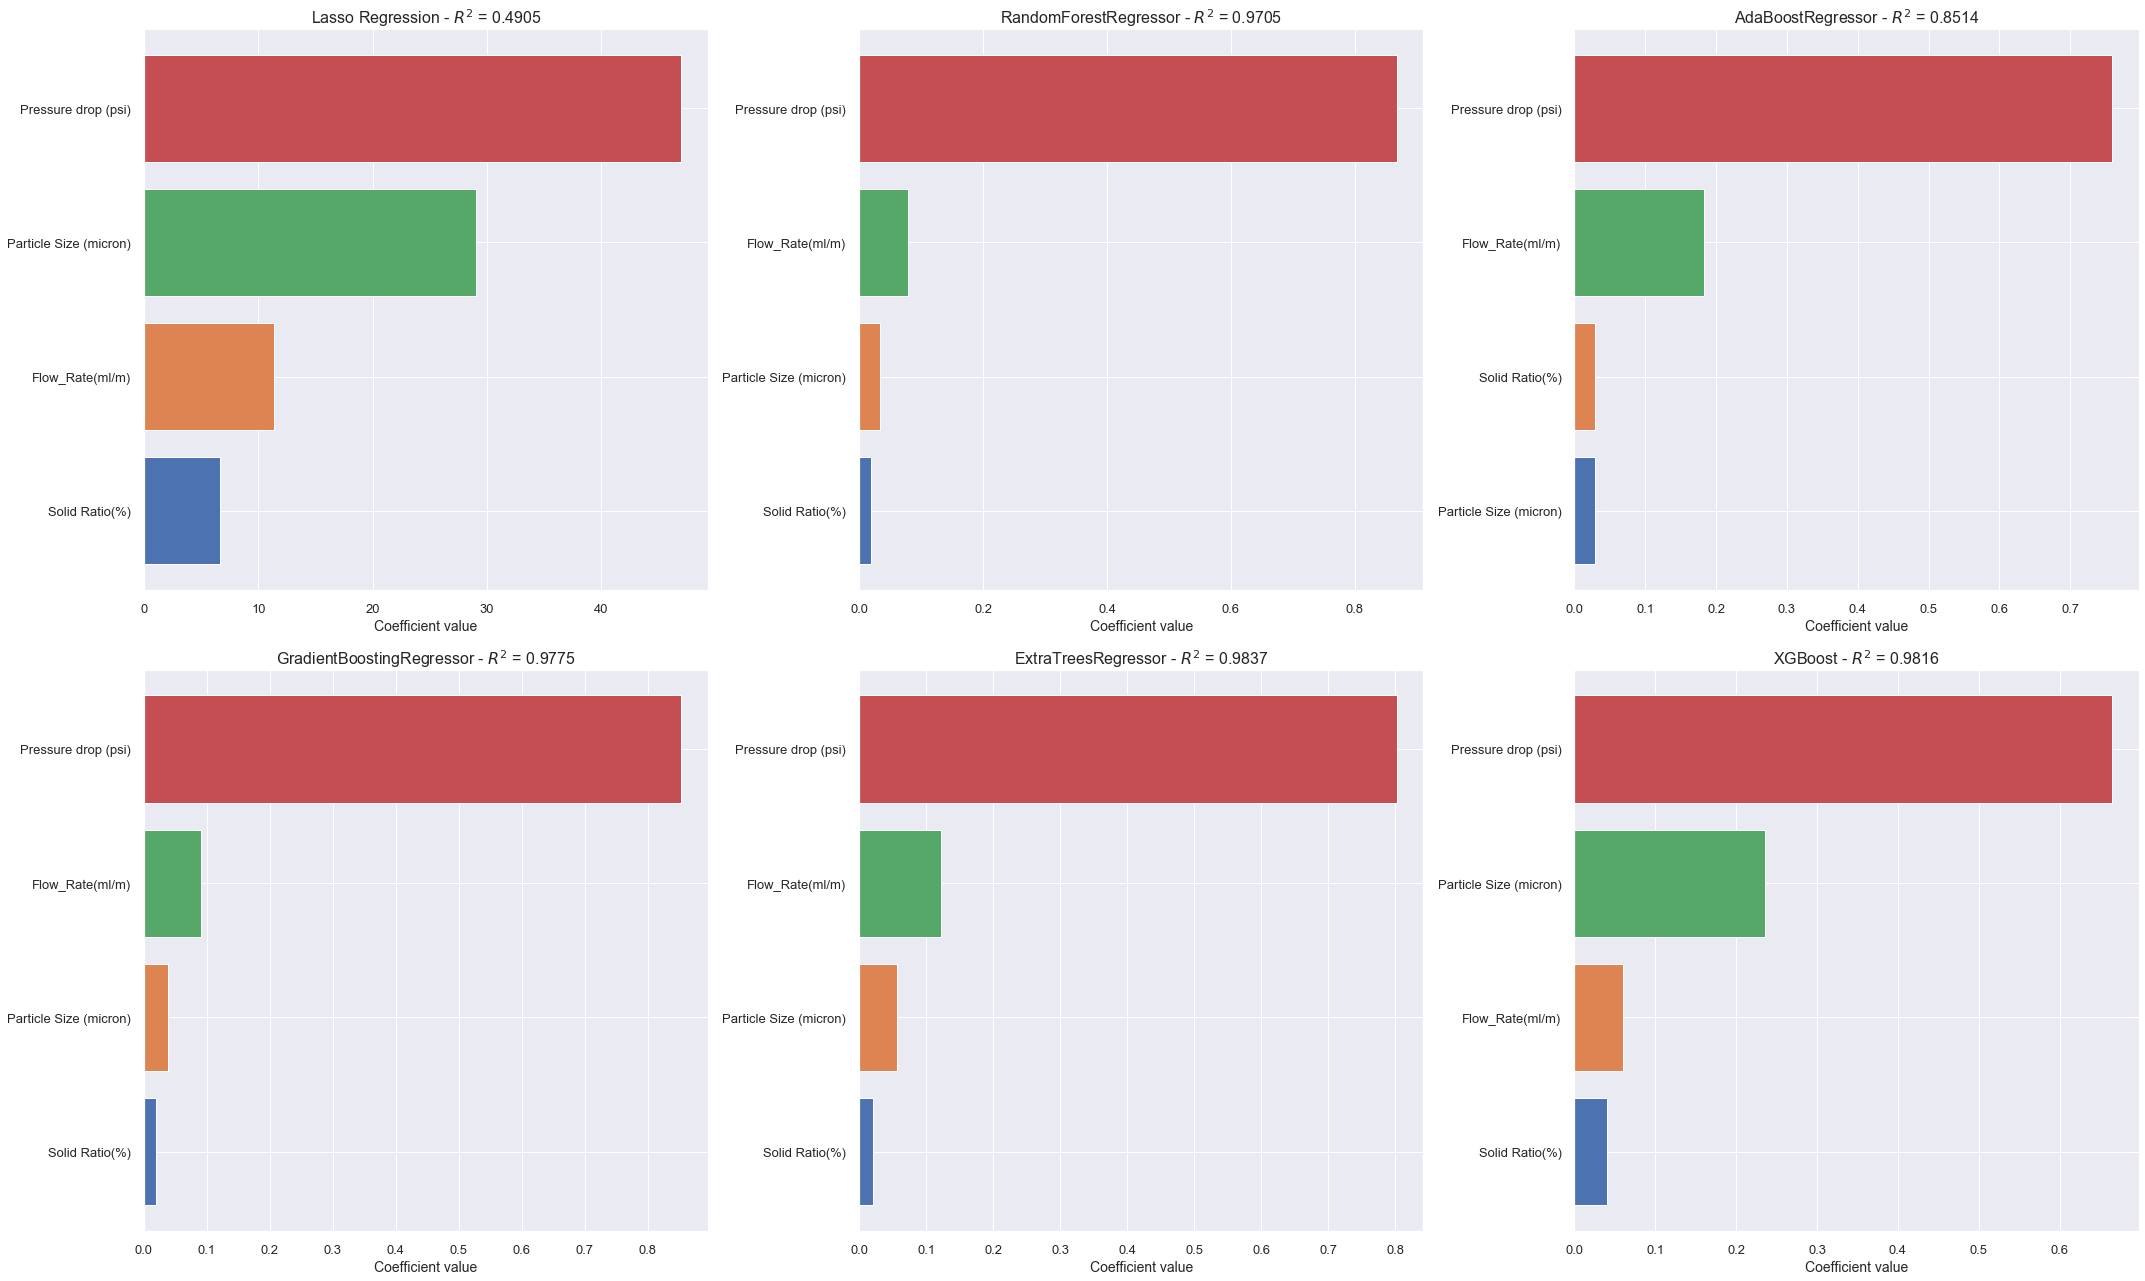

In [26]:
multi_select = multivariate_importance(X_scaled_train,X_scaled_test,y_train,y_test)
multi_select.plot(topn=4,relative=False)

Lets see how much worse the models are when removing the particle size

All models for determining feature importance
[Lasso(), RandomForestRegressor(random_state=0), AdaBoostRegressor(random_state=0), GradientBoostingRegressor(random_state=0), ExtraTreesRegressor(random_state=0), XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None, gpu_id=0,
             importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=0, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, seed=123, subsample=None,
             tree_method='gpu_hist', validate_parameters=None, verbosity=None)]

Obtaining feature importance - 0%
Obtaining feature importance - 50%


  0%|          | 0/6 [00:00<?, ?it/s]

Obtaining feature importance - 100%
Obtaining R2 score for all 6 models


100%|██████████| 6/6 [00:20<00:00,  3.46s/it]


R2 score calculated


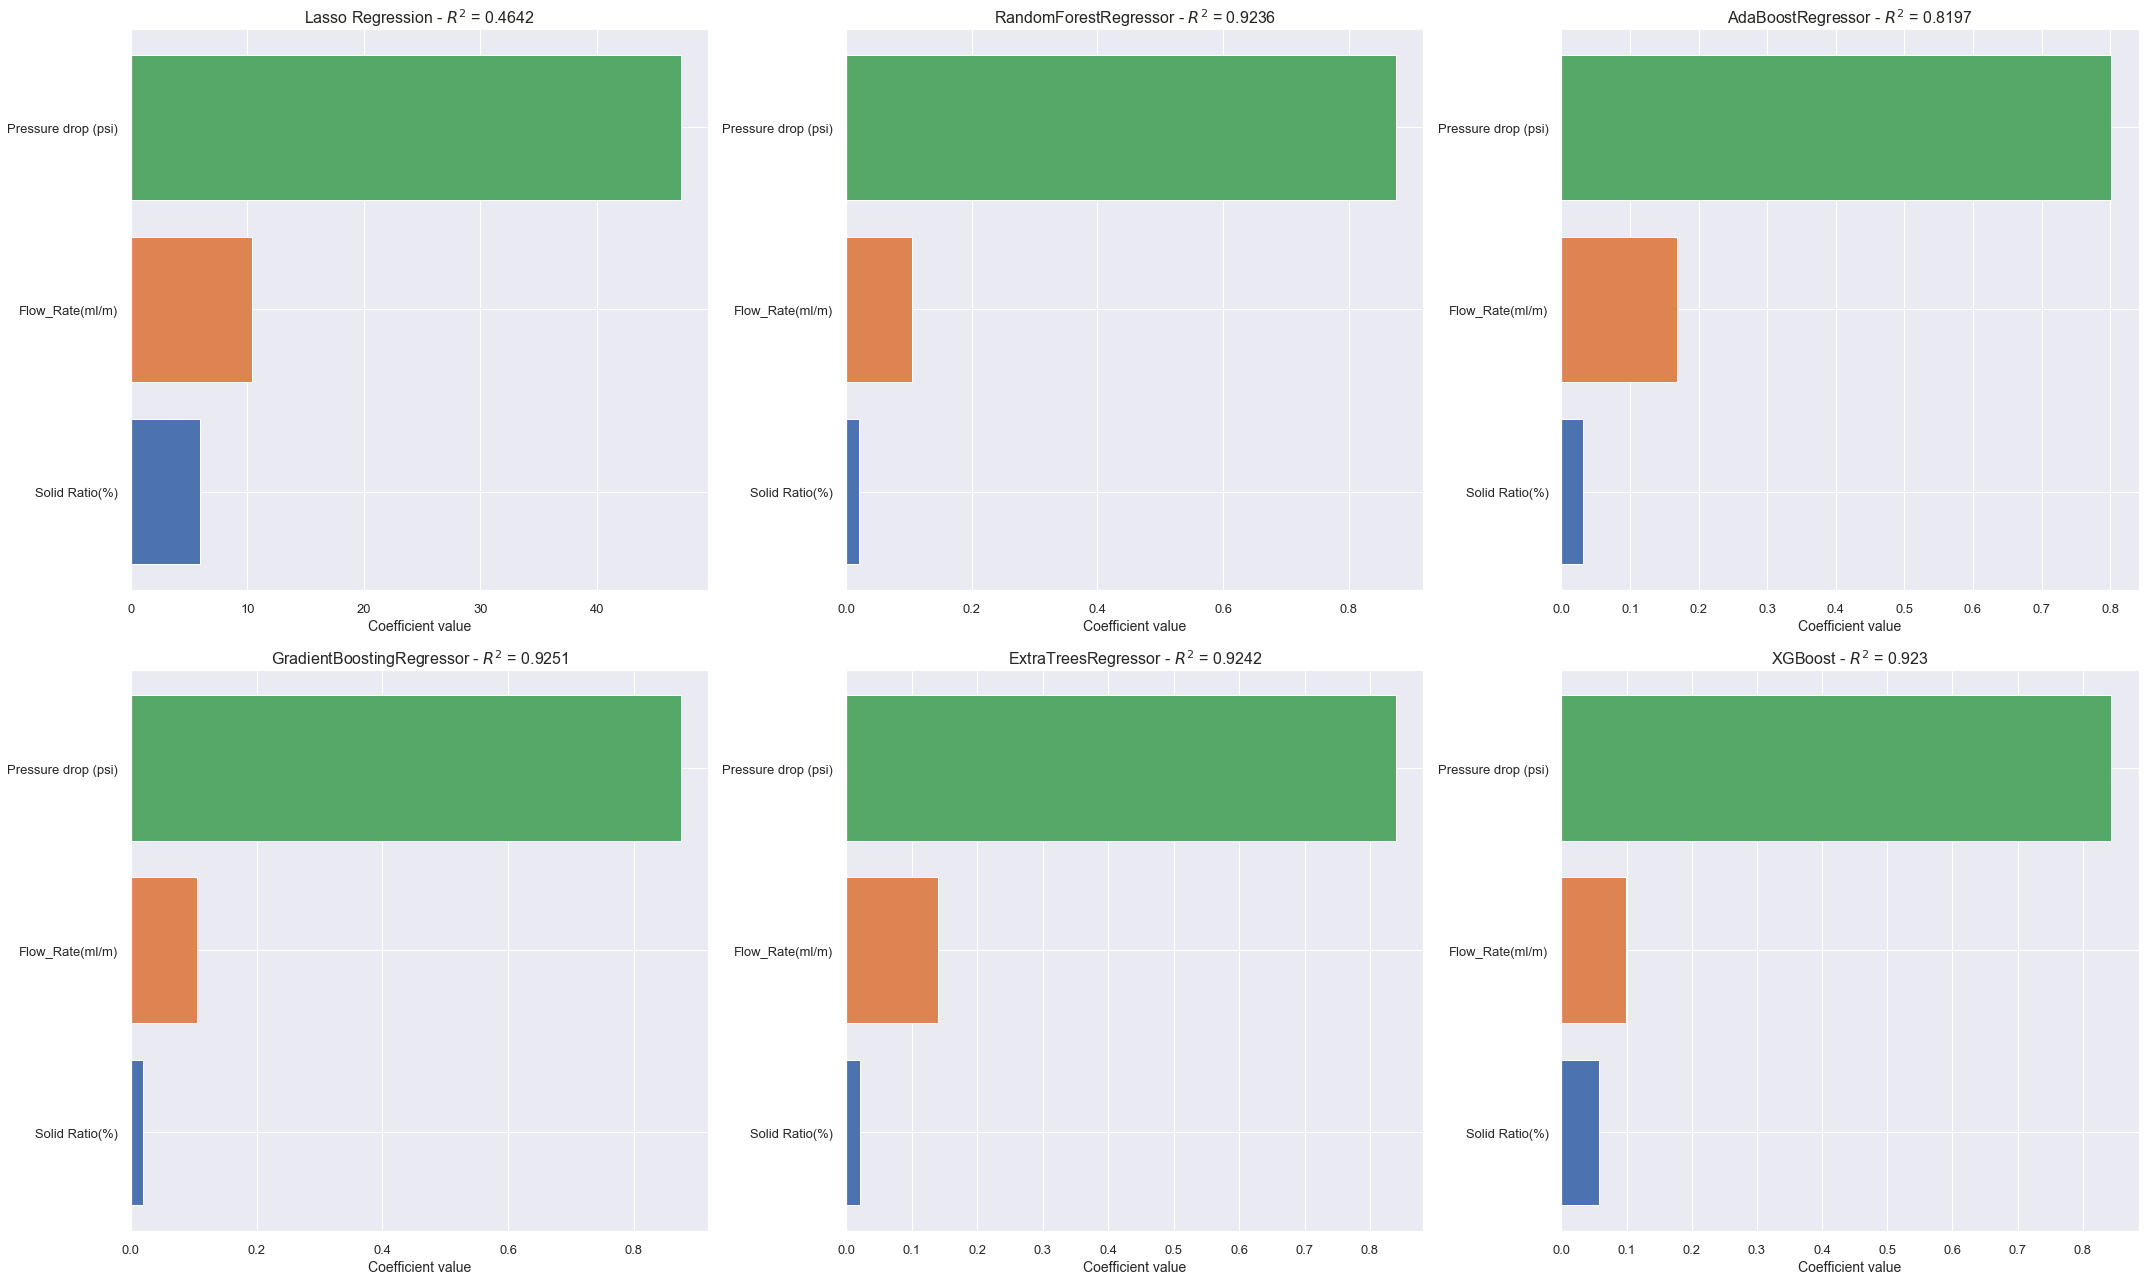

In [27]:
X_train=X_scaled_train.drop(['Particle Size (micron)'],axis=1)
X_test = X_scaled_test.drop(['Particle Size (micron)'],axis=1)

multi_select = multivariate_importance(X_train,X_test,y_train,y_test)
multi_select.plot(topn=3,relative=False)

Multivariate correlation revealed to use that the variables "solid ratio" and "particle size" are, indeed, important.

# Modeling the RUL forecasting as a regression problem

This sections is not useful for the data challenge

We would like to obtain the RUL 10 seconds into the future, therefore, must must create this objective column.

Since the sampling rate is 10 Hz (0.1s), we need to predict 100 samples into the future. 

In [28]:
# df_train

In [29]:
# HORIZON = 100 # 10 = 1s

# df_train['RUL_10s'] = df_train['RUL'].shift(-HORIZON) # Create future RUL column 
# df_train.dropna(inplace=True)
# df_train

In [30]:
# plt.plot(df_train['RUL'])

In [31]:
# known = df_train['RUL'].loc[0:1000] 
# unknown = df_train['RUL'].loc[1000:4000] 
# to_predict = df_train['RUL_10s'].loc[1000]

# feat1 = df_train['RUL'].loc[1000]

# fig, ax = plt.subplots()


# plt.scatter(1000,feat1, c='k', marker='o',label = 'Present RUL')
# plt.scatter(1000+HORIZON,to_predict, c='r', marker='o',label = 'RUL 10s into the future')


# known.plot(ax=ax, c='c', label = 'Known points',linewidth=3)
# unknown.plot(ax=ax, c='grey', alpha=0.5,label = 'Unknown points')


# ax.legend()
# ax.set_ylabel('RUL (s)')
# ax.set_xlabel('Number of time steps')

# Saving the dataset

In [32]:
df_export

,Flow_Rate(ml/m),Sample,Particle Size (micron),Solid Ratio(%),Pressure drop (psi),RUL
0,1.812877,1,0,0.400,0.910420,276.0
1,0.344843,1,0,0.400,0.878527,275.9
2,-1.163908,1,0,0.400,0.846992,275.8
3,-2.708819,1,0,0.400,0.815873,275.7
4,-4.284941,1,0,0.400,0.785227,275.6
...,...,...,...,...,...,...
69862,409.525546,48,1,0.475,19.354445,0.4
69863,409.866834,48,1,0.475,19.499287,0.3
69864,410.229758,48,1,0.475,19.643658,0.2
69865,410.613080,48,1,0.475,19.787507,0.1


In [34]:
df_export.to_csv('Processed_data/df_after_EDA.csv.zip',index=False,compression="zip")